## Assignment 3c

#### Submitted by:

#### **Calvin Smith**

#### **Bragadesh Bharatwaj Sundararaman**

#### **Amogha Udayakumar**

### Loading and cleaning data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Splitting into training and test set

train = pd.read_csv('PA3_train.tsv',sep = '\t',header = None)
test = pd.read_csv('PA3_test_clean.tsv',sep = '\t',header = None)

In [3]:
total_len = len(train)

print(len(train))
print(len(test))

7018
1751


In [4]:
# Changing columns names to something better: 

train.rename(columns = {0:'annot',1:'text'},inplace = True)
test.rename(columns = {0:'label',1:'text'},inplace = True)

In [5]:
# Removing the instances where the annotators do not agree
train = train.loc[(train['annot'] == '0/0') | (train['annot'] == '1/1')]

In [6]:
# Number of observations removed 

print(total_len - len(train))

396


In [7]:
# Creating new labels as 0 or 1 instead of 0/0 or 1/1

train['label'] = len(train)*0
for i in range(len(train)):
    if train['annot'].iloc[i] == '1/1':
        train['label'].iloc[i] = 1

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
# class balance training set

print(len(train[train['label']== 0])/len(train))
print(len(train[train['label']== 1])/len(train))

0.4720628209000302
0.5279371790999698


In [9]:
# class balance testing set

print(len(test[test['label']== 0])/len(test))
print(len(test[test['label']== 1])/len(test))

0.49400342661336377
0.5059965733866362


In [10]:
# dividing the training data into new training and validation sets for model building

train_temp, validation = train_test_split(train,test_size = 0.2)

In [11]:
len(train[train['label'] == 0])/len(train)

0.4720628209000302

In [12]:
len(train_temp[train_temp['label'] == 0])/len(train_temp)

0.4723428355673022

In [13]:
len(validation[validation['label'] == 0])/len(validation)

0.47094339622641507

# Naive Bayes

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [15]:
# Function for plotting the confusion matrix using Seaborn

def confusion_matrix_plot(cf_matrix):
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

In [16]:
# Function where we can try different Naive Bayes model and evaluate the accuracy before moving
# on to the test set.

def naive_bayes(train,validation,model_type,n_range,Alpha = 1.0,stopwords = []):
    
    tfidf = TfidfVectorizer(stop_words = stopwords,ngram_range = n_range)
    
    Xtrain = tfidf.fit_transform(train['text'])
    Xtest = tfidf.transform(validation['text'])

    if model_type == "multinomial":

        multi_NB = MultinomialNB(alpha = Alpha)
        clf = multi_NB.fit(Xtrain,train['label'])
        pred = clf.predict(Xtest)

        acc = accuracy_score(validation['label'],pred)
        conf_mat = confusion_matrix(validation['label'],pred)
        acc_class = [conf_mat[0,0]/(conf_mat[0,0]+conf_mat[1,0]),conf_mat[1,1]/(conf_mat[1,1]+conf_mat[0,1])]
     
    
    if model_type == "bernoulli":

        ber_NB = BernoulliNB(alpha = Alpha)
        clf = ber_NB.fit(Xtrain,train['label'])
        pred = clf.predict(Xtest)

        acc = accuracy_score(validation['label'],pred)
        conf_mat = confusion_matrix(validation['label'],pred)
        acc_class = [conf_mat[0,0]/(conf_mat[0,0]+conf_mat[1,0]),conf_mat[1,1]/(conf_mat[1,1]+conf_mat[0,1])]

    return acc, pred, acc_class, conf_mat


In [17]:
# Tuning the n-grams paramter for the TfidfVectorizer

acc_evaluation = []
best = -1
count = 1
for i in range(1,5):
    for j in range(count,5):
        acc, _, _, _= naive_bayes(train_temp,validation,'multinomial',(i,j))

        if acc > best:
            best = acc
            print(f'Current best: {best}')
            print(f'n_gram range = ({i},{j})')
        
    count = count + 1

Current best: 0.9584905660377359
n_gram range = (1,1)
Current best: 0.9683018867924529
n_gram range = (1,2)


In [19]:
# Tuning the alpha parameter for naive Bayes classifier

alpha = [0.05,0.1,0.2,0.3,0.5,0.8,1.0,1.2,1.5,2,3,10,15,20]
best = -1
acc_list = []
for i in alpha:
    acc, _, _, _ = naive_bayes(train_temp,validation,'multinomial',(1,2),i,[])
    acc_list.append(acc)

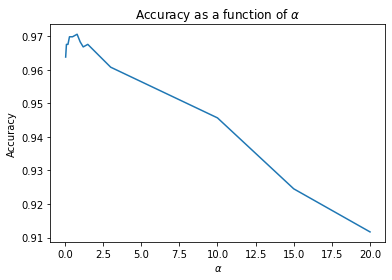

In [20]:
#Plotting Accuracy vs Alpha

plt.plot(alpha,acc_list)
plt.title(r'Accuracy as a function of $\alpha$')
plt.xlabel(r'$\alpha$')
plt.ylabel('Accuracy')
plt.show()

In [21]:
# Function that counts the frequency of ngrams from a text corpus.
# X = text corpus
# n = number of common and uncommon words to output
# ngram = should output be unigram, bigram, trigram etc.

def get_words(X,n,ngram):
  vect = CountVectorizer(ngram_range = ngram)  
  X_counts = vect.fit_transform(X.text)

  sum_words = X_counts.sum(axis = 0)

  words_freq = [(word, sum_words[0, idx]) for word, idx in     vect.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

  return words_freq[:n], words_freq[-n:]

In [22]:
# Top 10 most common and uncommon words in the training data

top, bottom = get_words(train,10,(1,1))
print('Top 10 most common words:\n', top)
print('\n Top 10 most uncommon words:\n', bottom)

Top 10 most common words:
 [('the', 14666), ('and', 11086), ('was', 6833), ('to', 6286), ('we', 4114), ('food', 3952), ('of', 3742), ('it', 3736), ('for', 3405), ('is', 3178)]

 Top 10 most uncommon words:
 [('relocated', 1), ('humble', 1), ('inspected', 1), ('offensively', 1), ('tapa', 1), ('pretensious', 1), ('nailing', 1), ('aimed', 1), ('cate', 1), ('steamer', 1)]


 Accuracy: 0.9668760708166761 
 Class accuracy: [0.9653979238754326, 0.9683257918552036]


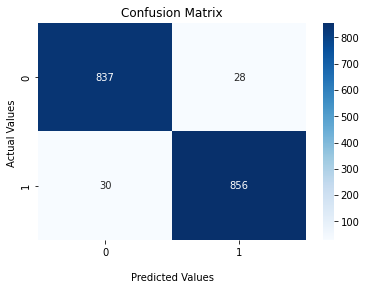

In [24]:
# Final evaluation

acc, pred,acc_class, cf_matrix = naive_bayes(train,test,'multinomial',(1,2),Alpha=0.2)
print(f' Accuracy: {acc} \n Class accuracy: {acc_class}')
confusion_matrix_plot(cf_matrix)

In [25]:
# To find instances where our model makes mistakes

index_list = []
for i in range(len(pred)):
    if pred[i] != test['label'].iloc[i]:
        index_list.append(i)

In [26]:
# Examples of the text where the model made mistakes

print('Actual Value:',test['label'].iloc[index_list[5]],'Prediction:',pred[index_list[5]],'\nText:',test['text'].iloc[index_list[5]], '\n\nActual Value:',test['label'].iloc[index_list[5]],'Prediction:',pred[index_list[5]],'\nText:', test['text'].iloc[index_list[15]], '\n\nActual Value:',test['label'].iloc[index_list[5]],'Prediction:',pred[index_list[5]],'\nText:', test['text'].iloc[index_list[25]])

Actual Value: 1 Prediction: 0 
Text: Great burgers. I heard some pretty bad press about this place, but everything from food to staff and interior was more than good enough. 

Actual Value: 1 Prediction: 0 
Text: I am a very picky eater who dislikes pork, however, Schiller Braeu made me change my mind about German food. Before I went to Germany, I decided to eat nothing but pastry as I did in Vienna years ago. I went restaurants just to keep my husband company and only had a few bites of his meat dishes. At Schiller Braeu I learned to enjoy German sausages and potato sides. Even the sour sauerkraut in Germany was delicious, unlike what we buy from North American market. The restaurant has a very pleasant local atmosphere and the most hard-working waitresses considering how many large glasses of beer that they had to carry! 

Actual Value: 1 Prediction: 0 
Text: Bizarre place with lukewarm welcome


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=190c7b43-b754-4fd5-a62f-1a140edc140a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>